Relaxed entropy dual, where we estimate $\varphi$ only, replacing $\psi$ with first order optimality condition.

In [3]:
from data_utils import create_joint_x_y
import numpy as np
from torch import nn
import torch

def torch_sphere_uniform(n, d, **kwargs):
    """Generate n points inside the d-dimensional sphere."""
    random_vectors = torch.randn(n, d, **kwargs)
    vectors_norms = torch.norm(random_vectors, dim=1, keepdim=True)
    radius = torch.pow(torch.rand(n, 1, **kwargs), 1. / d)
    return radius * random_vectors / vectors_norms

num_points_to_generate = 1000
X, Y = create_joint_x_y(num_points_to_generate)

n, d = Y.shape
m = n

phi_network = nn.Sequential(
    nn.Linear(d + X.shape[1], 100),
    nn.Softplus(),
    nn.Linear(100, 100),
    nn.Softplus(),
    nn.Linear(100, 1)
)

In [7]:
import torch
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
epsilon = 1e-5
num_epochs = 5000

phi_network.to(**device_and_dtype_specifications)
phi_network_optimizer = torch.optim.Adam([dict(params=phi_network.parameters())], lr=0.01)

X, Y = create_joint_x_y(num_points_to_generate)
X_tensor = torch.tensor(X, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
dataset_size = num_points_to_generate
batch_size = 64


def estimate_gradient_of_psi(X_tensor, Y_tensor, phi_net, epsilon=0.1):
        """
        Estimate the dual objective term for entropy estimation.

        This function implements the core calculation based on nearest neighbors and learned
        potential functions phi and psi. It offers an option to oversample some x's to better approximate P(Y|X)

        Args:
        X_tensor (torch.Tensor): The input tensor for x, with shape [n, p].
        Y_tensor (torch.Tensor): The input tensor for y, with shape [n, q].
        U_tensor (torch.Tensor): The tensor of oversampled variables u, with shape [m, q].
        phi_net (nn.Module): The neural network representing the potential function phi(u, x).
        psi_net (nn.Module): The neural network representing the potential function psi(x, y).
        k (int, optional): The number of nearest neighbors to use. Defaults to 5.
        epsilon (float, optional): A small positive constant for the calculation. Defaults to 0.1.

        Returns:
        torch.Tensor: A scalar tensor representing the estimated dual value.
        """
        # Get dimensions from input tensors
        n, _ = X_tensor.shape
        m = 100

        U_tensor_numerator = torch.randn(m, Y_tensor.shape[1], **device_and_dtype_specifications, requires_grad=True)
        U_tensor_denominator = torch.randn(m, Y_tensor.shape[1], **device_and_dtype_specifications, requires_grad=True)

        U_tensor_numerator_expanded = U_tensor_numerator.unsqueeze(0).expand(n, -1, -1)  # Shape: [n, m, q] [:, i, :] = u_i
        U_tensor_denominator_expanded = U_tensor_denominator.unsqueeze(0).expand(n, -1, -1)  # Shape: [n, m, q] [:, i, :] = u_i

        X_expanded_for_U = X_tensor.unsqueeze(1).expand(-1, m, -1)  # Shape: [n, m, p] [i, :, :] = x_i
        XU_numerator = torch.cat((X_expanded_for_U, U_tensor_numerator_expanded), dim=-1) # Shape: [n, m, q + p] [i, j] = torch.cat[x_j, u_i]
        XU_denominator = torch.cat((X_expanded_for_U, U_tensor_denominator_expanded), dim=-1) # Shape: [n, m, q + p] [i, j] = torch.cat[x_j, u_i]

        numerator = phi_net(XU_numerator) # Shape: [n, m, 1]
        numerator_gradient = torch.autograd.grad(numerator.sum(), U_tensor_numerator)[0] # Shape: [m, q]
        print(numerator_gradient.shape, numerator.shape)
        raise Exception("Stop here")
        # denominator = phi_net(XU_denominator) # Shape: [n, m, 1]
        # denominator_gradient = torch.autograd.grad(denominator.sum(), U_tensor_denominator)[0] # Shape: [m, q]

        # psi_estimate = torch.mean(phi_vals_numerator_gradient - phi_vals_denominator_gradient)

        # return psi_estimate

        # U_expanded = U_tensor.unsqueeze(0).expand(n, -1, -1)  # Shape: [n, m, q] [:, i, :] = u_i
        # X_expanded_for_U = X_tensor.unsqueeze(1).expand(-1, m, -1)  # Shape: [n, m, p] [i, :, :] = x_i
        # XU = torch.cat((X_expanded_for_U, U_expanded), dim=-1) # Shape: [n, m, q + p] [i, j] = torch.cat[x_j, u_i]

        # phi_vals = phi_net(XU).squeeze(-1)  # Shape: [n, m] [i, j] = phi(u_i, x_j)
        # cost_matrix = Y_tensor @ U_tensor.T # Shape: [n, m] [i, j] = y_j @ u_i

        # slackness = cost_matrix - phi_vals    # Shape: [n, m]

        # log_mean_exp = torch.logsumexp(slackness / epsilon, dim=1, keepdim=True) \
        #         - torch.log(torch.tensor(m, device=slackness.device, dtype=slackness.dtype))

        # psi_estimate = epsilon * log_mean_exp

        # return psi_estimate


for epoch_idx in range(1, num_epochs):

        phi_network.zero_grad()

        yindexes = torch.randint(0, dataset_size, (batch_size,))

        X_batch = X_tensor[yindexes]
        Y_batch = Y_tensor[yindexes]
        U_batch = torch.randn(
                batch_size, Y_batch.shape[1],
                **device_and_dtype_specifications
        )

        phi = phi_network(torch.cat([X_batch, U_batch], dim=1))

        objective = torch.mean(phi)
        objective.backward()

        psi = estimate_gradient_of_psi(
                X_tensor=X_batch,
                Y_tensor=Y_batch,
                phi_net=phi_network,
                epsilon=epsilon
        )

        phi_network_optimizer.step()
        print(objective.item(), epoch_idx)

_ = phi_network.eval()

torch.Size([100, 2]) torch.Size([64, 100, 1])


Exception: Stop here

In [8]:
import matplotlib.pyplot as plt

%matplotlib qt

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
number_of_points_to_visualize = 1000

with torch.no_grad():
        U_tensor = torch.randn(number_of_points_to_visualize, d, **device_and_dtype_specifications)
        UX_tensor = X_tensor[50:51].repeat(number_of_points_to_visualize, 1)
        potential_tensor = phi_network(torch.cat([UX_tensor, U_tensor], dim=1))

potential = potential_tensor.detach().cpu().numpy()
U = U_tensor.detach().cpu().numpy()
scatter = ax.scatter(U[:, 0], U[:, 1], potential.squeeze(), color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

In [9]:
# Change to %matplotlib qt to have interactive plots
%matplotlib qt

from data_utils import create_conditional_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100])[:, None]

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_/100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):

    x = torch.tensor([x_ / 100], **device_and_dtype_specifications)[:, None]
    x = x.repeat(repeats=(100, 1))

    colors = ['red', 'purple', 'green', 'orange', 'blue']
    radii = [0.1, 0.5, 1., 1.5, 2]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True

        potential = phi_network(torch.cat([x, u_tensor], dim=1))
        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        z_line = x.detach().cpu().numpy()
        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

We can add additional parameter update loop with frozen network weights to prevent the quantile crossing effect.

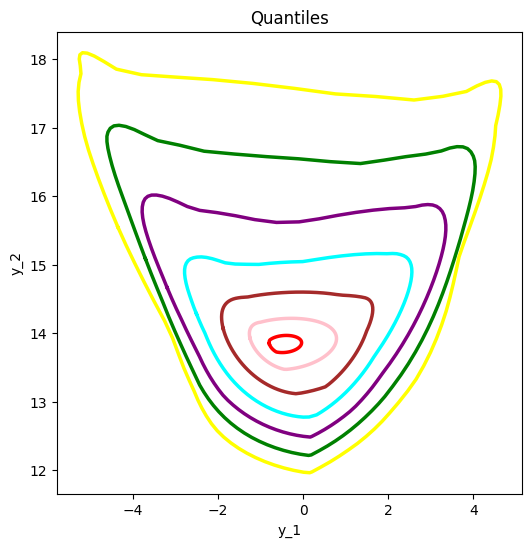

In [12]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.set_title('Quantiles')
ax1.set_xlabel('y_1')
ax1.set_ylabel('y_2')
x = torch.tensor([2.4], **device_and_dtype_specifications)[:, None]
x = x.repeat(u_tensor.shape[0], 1)


colors = ['red', 'pink', 'brown', 'cyan', 'purple', 'green', 'yellow']
radii = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4]
for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True


        potential = phi_network(torch.cat([x, u_tensor], dim=1))
        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], color=color, linewidth=2.5)
